In [97]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
np.random.seed(7)

## Analysis

In [98]:
X = idx2numpy.convert_from_file('Data/MNIST/train-images.idx3-ubyte')
y = idx2numpy.convert_from_file('Data/MNIST/train-labels.idx1-ubyte')

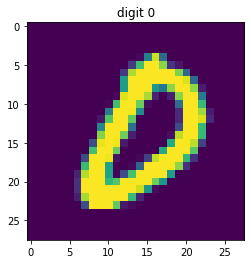

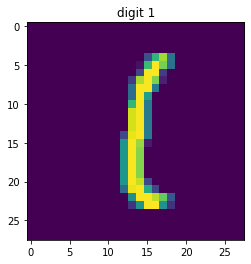

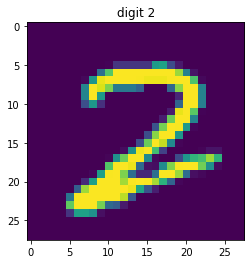

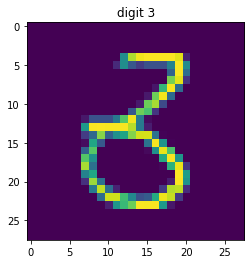

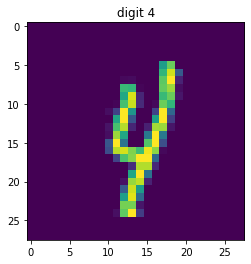

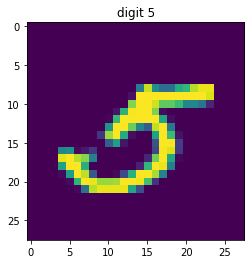

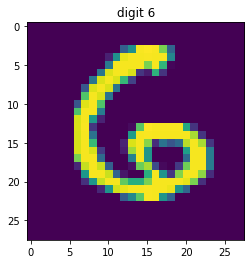

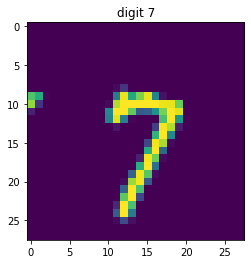

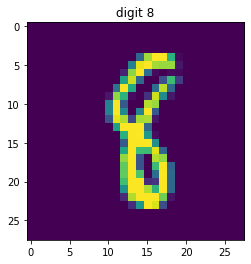

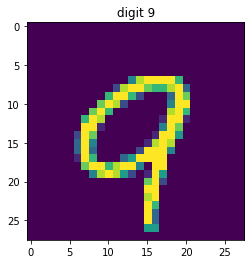

In [99]:
for digit in range(10):
    samples = X[y == digit]
    random_samples = np.random.choice(range(0, len(samples)), 1) # MAKE IT 5 !TODO
    for i in random_samples:
        plt.imshow(samples[i])
        plt.title(f'digit {digit}')
        plt.show()

In [100]:
def split(X, y, folds=5, shuffle=True):
    assert X.shape[0] == y.shape[0]
    n = X.shape[0]
    if shuffle:
        p = np.random.permutation(n)
        X, y = X[p], y[p]
    num = n // folds
    left = n % folds
    X_folds = []
    y_folds = []
    prev = 0
    for i in range(folds):
        length = num + (left > 0)
        X_ = np.copy(X[prev: prev + length])
        y_ = np.copy(y[prev: prev + length])
        X_folds.append(X_)
        y_folds.append(y_)
        prev += length
        left -= 1
    return X_folds, y_folds

def form_train_val(X_folds, y_folds, val_fold):
    train_X_folds = [X_folds[i] for i in range(len(X_folds)) if i != val_fold]
    train_y_folds = [y_folds[i] for i in range(len(y_folds)) if i != val_fold]
    train_X = np.concatenate(train_X_folds, axis=0)
    train_y = np.concatenate(train_y_folds, axis=0)
    val_X = np.copy(X_folds[val_fold])
    val_y = np.copy(y_folds[val_fold])
    return train_X, train_y, val_X, val_y

In [101]:
def BCE(y_actual, y_pred):
    return -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))
    
def accuracy(y_actual, y_pred):
    return sum([y_pred[i] == y_actual[i] for i in range(len(y_actual))]) / len(y_actual)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))